In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/rene/Development/LLM/z/scratch-llm


In [1]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.1.0.post301


In [2]:
llm_config = LLMConfig(
    vocab_size=18_000, # 2_000
    context_size=512, # 64
    dim_emb=2048, # 256
    num_layers=7, # 4
    num_heads=8,
    emb_dropout=0.0,
    ffd_dim_hidden=4 * 512,
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    batch_size=32, # 64
    learning_rate=3e-4,
    weight_decay=1e-5,
    max_steps=20_000, # 3_000, # 4_000
    log_frequency=1,
)

In [3]:
input_file = "data/shakespeare/simonyi.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [4]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

X, y = ds_train.get_batch(batch_size=8)

print(X.shape, y.shape)

torch.Size([8, 512]) torch.Size([8, 512])


In [5]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 243,134,416
model size: 936.234MB


In [6]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on cuda.


/home/rene/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


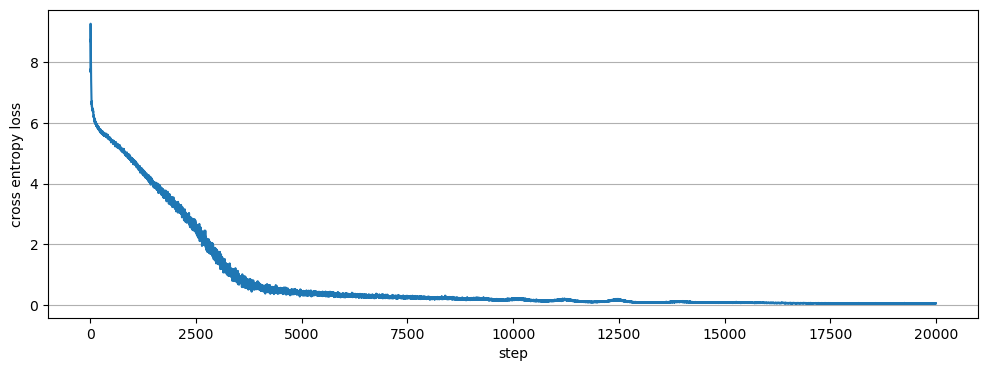

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

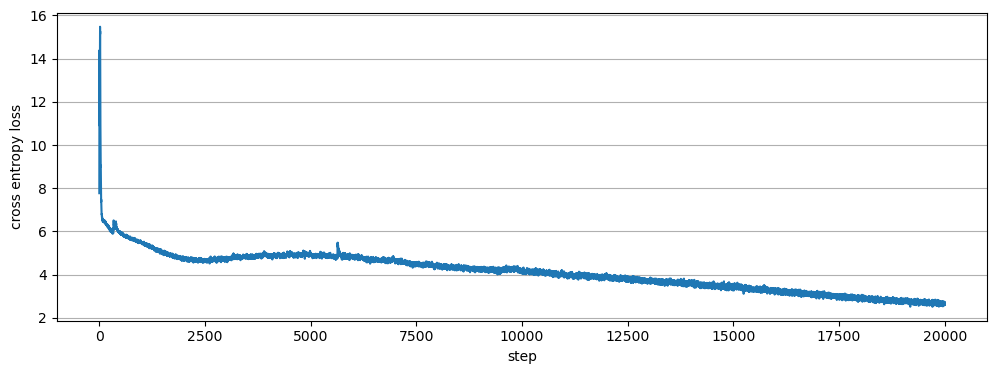

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

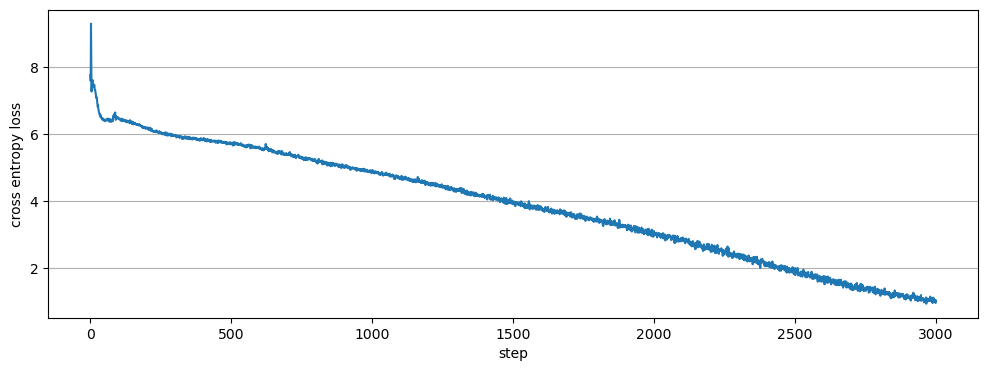

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

In [17]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32).to(train_config.device)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'schlossen wurde. an der Jahrtausend wichtign vor sich gehen, daß ein g2 einfallenden Energie immerein großer Teilchen in'

In [13]:
# generate from a prompt
for i in range(11):
    prompt = (
        tokenizer.encode(
            "Grundsätzlich lässt sich sagen, dass ",
            beg_of_string=True,
            pad_seq=True,
            seq_len=llm_config.context_size,
        )
        .view(1, -1)
        .to(train_config.device)
    )
    out = model.generate(prompt, max_seq_len=30)
    print(tokenizer.decode(out))

Grundsätzlich lässt sich sagen, dass; die Klege Geänderten Wahl spezifischer) zu erbroch. Zweifel, daß eine Meinung der Spaltung
Grundsätzlich lässt sich sagen, dasswunderlich ist er), kannischen ähnlichen Sflos sieh nicht unannmäßig oder ohne Auslangjähriger Fr
Grundsätzlich lässt sich sagen, dassech gegen möglichen unbewegten gewesen: , irgendwogä, ob wenn aus den Erfahrung Ich hergeleitet worden sind
Grundsätzlich lässt sich sagen, dass sie geli tbehrent und das Ende des dabei mageemförmige  T 53 f Möglichkeit auf gl
Grundsätzlich lässt sich sagen, dass möglichern als einen verscheren.4), und eine gewonnene zuweipfenzühle gewesen, und damit die damit möglich
Grundsätzlich lässt sich sagen, dass auf Tagante, und (17längen - 1 und diese Beseitigung nicht mit der Wissenschaft auch die Anhänger des was als 3. F
Grundsätzlich lässt sich sagen, dass vor. Inken6 nicht h auf Realität wirkkungen auf diesen bedeutet das Verhalten für die Notwendigkeit zu sehen, wobei mehreren F
Grundsätzlich 

In [14]:
⁇

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [15]:
!ls -al data/shakespeare/ti*


-rw-rw-r-- 1 rene rene  269703 Mär 30 20:16 data/shakespeare/tinyshakespeare.model
-rw-rw-r-- 1 rene rene 1115393 Mär 30 20:16 data/shakespeare/tinyshakespeare.txt
-rw-rw-r-- 1 rene rene   33763 Mär 30 20:16 data/shakespeare/tinyshakespeare.vocab


In [16]:
AT0010000000000000001000001713033

NameError: name 'AT0010000000000000001000001713033' is not defined